_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Student name: Arne Gittel, Artemii Shlychhkov, Elias Seiffert

# Coding Lab 3

- __Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

Two-photon imaging is widely used to study computations in populations of neurons. In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For analysis, please resample it to 25 Hz using `scipy.signal.decimate`.

In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
from __future__ import annotations
import oopsi
from scipy.ndimage import gaussian_filter1d


%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-05-28 16:40:25Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.24.0

sklearn: 1.4.2

seaborn   : 0.13.2
pandas    : 2.2.2
matplotlib: 3.8.4
numpy     : 1.26.4
scipy     : 1.13.0

Watermark: 2.4.3



In [117]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [118]:
# ogb dataset from Theis et al. 2016 Neuron
# ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
# ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)

# # gcamp dataset from Chen et al. 2013 Nature
# gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
# gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)


# Workaround For loading the data on my laptop

import os

data_path = r"C:\Users\Arne.Gittel\Documents\Neuro Master\Neural data science\practicals\notebooks\data"

# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv(os.path.join(data_path, "nds_cl_3_ogb_calcium.csv"), header=0)
ogb_spikes = pd.read_csv(os.path.join(data_path, "nds_cl_3_ogb_spikes.csv"), header=0)

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv(
    os.path.join(data_path, "nds_cl_3_gcamp2_calcium.csv"), header=0
)
gcamp_spikes = pd.read_csv(
    os.path.join(data_path, "nds_cl_3_gcamp2_spikes.csv"), header=0
)

In [119]:
ogb_calcium.shape, ogb_spikes.shape, gcamp_calcium.shape, gcamp_spikes.shape

((71986, 11), (71986, 11), (23973, 37), (23973, 37))

In [120]:
ogb_spikes.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
1,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
2,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
3,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
4,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Zoom in on a small segment of tens of seconds and offset the traces such that a valid comparison is possible.

*Grading: 2 pts*

C:\Users\Arne.Gittel\AppData\Local\Temp\ipykernel_19884\549869172.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


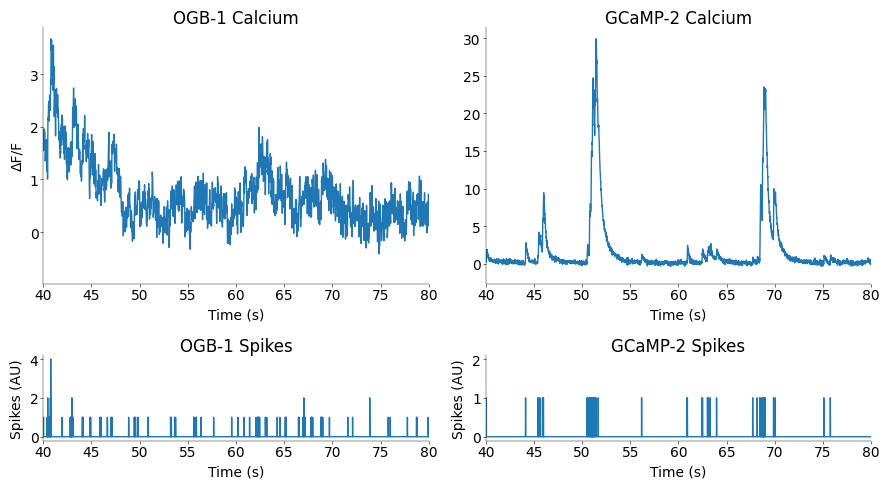

In [121]:
sampling_rate = 100  # Hz
timeline_ogb = np.arange(0, ogb_calcium.shape[0] / sampling_rate, 1 / sampling_rate)
timeline_gcamp = np.arange(0, gcamp_calcium.shape[0] / sampling_rate, 1 / sampling_rate)

fig, axs = plt.subplots(
    2, 2, figsize=(9, 5), height_ratios=[3, 1], layout="constrained"
)

axs[0, 0].plot(timeline_ogb, ogb_calcium["5"], label="OGB-1")
axs[0, 0].set_title("OGB-1 Calcium")
axs[0, 0].set_ylabel("\u0394" + "F/F")
axs[0, 0].set_xlabel("Time (s)")
axs[0, 0].set_xlim([40, 80])

axs[0, 1].plot(timeline_gcamp, gcamp_calcium["6"], label="GCaMP-2")
axs[0, 1].set_title("GCaMP-2 Calcium")
axs[0, 1].set_ylabel("")
axs[0, 1].set_xlabel("Time (s)")
axs[0, 1].set_xlim([40, 80])

axs[1, 0].plot(timeline_ogb, ogb_spikes["5"], label="OGB-1")
axs[1, 0].set_title("OGB-1 Spikes")
axs[1, 0].set_ylabel("Spikes (AU)")
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_xlim([40, 80])

axs[1, 1].plot(timeline_gcamp, gcamp_spikes["6"], label="GCaMP-2")
axs[1, 1].set_title("GCaMP-2 Spikes")
axs[1, 1].set_ylabel("Spikes count")
axs[1, 1].set_xlabel("Time (s)")
axs[1, 1].set_xlim([40, 80])

plt.tight_layout()
plt.show()

In [122]:
# resample data to 25 Hz
resample_rate = 25

ogb_calcium_resampled = signal.decimate(ogb_calcium, 4, axis=0)
gcamp_calcium_resampled = signal.decimate(gcamp_calcium, 4, axis=0)
ogb_spikes_resampled = signal.decimate(ogb_spikes, 4, axis=0)
gcamp_spikes_resampled = signal.decimate(gcamp_spikes, 4, axis=0)

ogb_spikes_resampled[ogb_spikes_resampled < 0] = 0  # Remove decimation artifacts
gcamp_spikes_resampled[gcamp_spikes_resampled < 0] = 0  # Remove decimation artifacts

(17997,)


C:\Users\Arne.Gittel\AppData\Local\Temp\ipykernel_19884\687036474.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


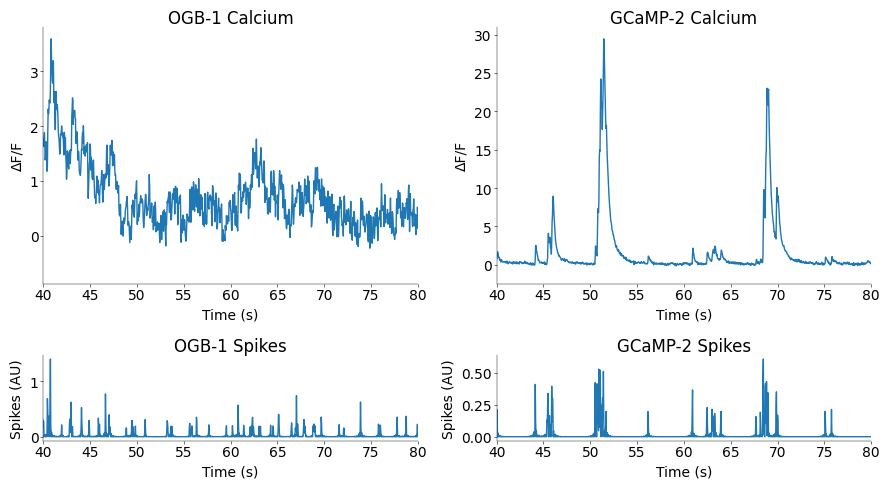

In [123]:
timeline_ogb_resampled = np.arange(
    0, ogb_calcium_resampled.shape[0] / resample_rate, 1 / resample_rate
)

print(timeline_ogb_resampled.shape)

timeline_gcamp_resampled = np.arange(
    0, gcamp_calcium_resampled.shape[0] / resample_rate, 1 / resample_rate
)


fig, axs = plt.subplots(
    2, 2, figsize=(9, 5), height_ratios=[3, 1], layout="constrained"
)

axs[0, 0].plot(timeline_ogb_resampled, ogb_calcium_resampled[:, 5], label="OGB-1")
axs[0, 0].set_title("OGB-1 Calcium")
axs[0, 0].set_ylabel("\u0394" + "F/F")
axs[0, 0].set_xlabel("Time (s)")
axs[0, 0].set_xlim([40, 80])

axs[0, 1].plot(timeline_gcamp_resampled, gcamp_calcium_resampled[:, 6], label="GCaMP-2")
axs[0, 1].set_title("GCaMP-2 Calcium")
axs[0, 1].set_ylabel("\u0394" + "F/F")
axs[0, 1].set_xlabel("Time (s)")
axs[0, 1].set_xlim([40, 80])

axs[1, 0].plot(timeline_ogb_resampled, ogb_spikes_resampled[:, 5], label="OGB-1")
axs[1, 0].set_title("OGB-1 Spikes")
axs[1, 0].set_ylabel("Spikes (AU)")
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_xlim([40, 80])

axs[1, 1].plot(timeline_gcamp_resampled, gcamp_spikes_resampled[:, 6], label="GCaMP-2")
axs[1, 1].set_title("GCaMP-2 Spikes")
axs[1, 1].set_ylabel("Spikes (AU)")
axs[1, 1].set_xlabel("Time (s)")
axs[1, 1].set_xlim([40, 80])

plt.tight_layout()
plt.show()

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). As we know that there can be no negative rates, apply a heavyside function to the output. Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this.

*Grading: 3 pts*


In the paper a smoothing and filter function was used to preprocess the data:

#### Apply low pass filter to data

In [124]:
# set cutoff to 0.2 times the frame rate as in the paper
cutoff = 0.2 * resample_rate

b, a = signal.butter(2, cutoff, btype="low", fs=resample_rate)

# filter the data
ogb_calcium_filtered = signal.filtfilt(b, a, ogb_calcium_resampled, axis=0)
gcamp_calcium_filtered = signal.filtfilt(b, a, gcamp_calcium_resampled, axis=0)

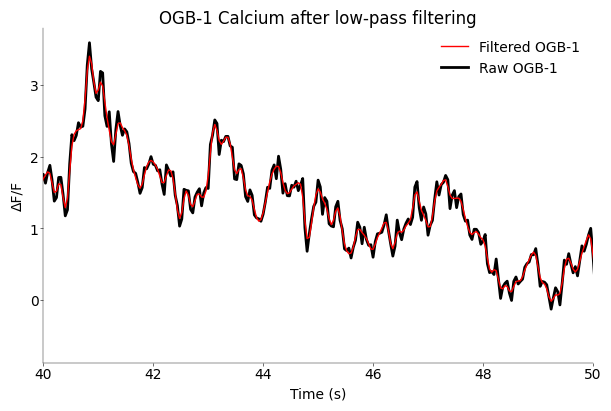

In [125]:
# plot filtered ogb data
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(
    timeline_ogb_resampled,
    ogb_calcium_filtered[:, 5],
    label="Filtered OGB-1",
    linewidth=1,
    color="red",
    zorder=10,
    alpha=1,
)
ax.set_title("Filtered OGB-1 Calcium")
ax.set_ylabel("\u0394" + "F/F")
ax.set_xlabel("Time (s)")
ax.set_xlim([40, 50])

# plot filtered gcamp data
ax.plot(
    timeline_ogb_resampled,
    ogb_calcium_resampled[:, 5],
    label="Raw OGB-1",
    zorder=5,
    alpha=1,
    linewidth=2,
    color="black",
)
ax.set_title("OGB-1 Calcium after low-pass filtering")
ax.set_ylabel("\u0394" + "F/F")
ax.set_xlabel("Time (s)")
plt.legend()

In [126]:
ogb_calcium_filtered_saved = np.copy(ogb_calcium_filtered)  # save for later
gcamp_calcium_filtered_saved = np.copy(gcamp_calcium_filtered)  # save for later

#### Define the smoothing function (as in the paper)

In [127]:
def smooth_signal(x, max_iter=200):
    sample = np.copy(x)  # make a copy of the signal
    for iterations in range(max_iter):
        peaks = signal.find_peaks(sample, height=None)[0]  # find peaks
        throughs = signal.find_peaks(-sample, height=None)[0]  # find throughs
        extrema = np.sort(
            np.concatenate([peaks, throughs])
        )  # sorted union of peaks and throughs

        # find the peak with the minimum amplitude as defined by the difference between the current extremum and the previous one

        min_abs_amp = 999
        for i in range(1, len(extrema)):
            abs_amp = np.abs(sample[extrema[i]] - sample[extrema[i - 1]])
            if abs_amp < min_abs_amp:
                min_abs_amp = abs_amp
                min_abs_amp_idx = i
        # print(min_abs_amp)

        # if the minimum amplitude is greater than 1 - threshold indicated in the paper, we can stop
        if min_abs_amp > 1:
            break

        # get the previous, current, and next extrema - window of smoothing

        center_extremum = extrema[min_abs_amp_idx]
        previous_extremum = extrema[
            min_abs_amp_idx - 1 if min_abs_amp_idx - 1 >= 0 else 0
        ]
        next_extremum = extrema[
            min_abs_amp_idx + 1 if min_abs_amp_idx + 1 < len(extrema) else -1
        ]

        # smooth the signal by averaging the extrema within the window with its neighbors

        for i in range(3):
            sample[center_extremum] = np.mean(
                sample[center_extremum - 1 : center_extremum + 2]
            )
            sample[previous_extremum] = np.mean(
                sample[previous_extremum - 1 : previous_extremum + 2]
            )
            sample[next_extremum] = np.mean(
                sample[next_extremum - 1 : next_extremum + 2]
            )
    return sample  # return the smoothed signal

#### Apply the smoothing function to the data

In [128]:
batch_length = 10  # seconds
number_of_batches_ogb = timeline_ogb_resampled.shape[0] // (
    batch_length * resample_rate
)
number_of_batches_gcamp = timeline_gcamp_resampled.shape[0] // (
    batch_length * resample_rate
)

for i in range(number_of_batches_ogb):
    start = i * batch_length * resample_rate
    end = (i + 1) * batch_length * resample_rate
    smoothed_data = smooth_signal(ogb_calcium_filtered[start:end, 5], max_iter=5000)
    ogb_calcium_filtered[start:end, 5] = smoothed_data

for i in range(number_of_batches_gcamp):
    start = i * batch_length * resample_rate
    end = (i + 1) * batch_length * resample_rate
    smoothed_data_gcamp = smooth_signal(
        gcamp_calcium_filtered[start:end, 6], max_iter=5000
    )
    gcamp_calcium_filtered[start:end, 6] = smoothed_data_gcamp

C:\Users\Arne.Gittel\AppData\Local\Temp\ipykernel_19884\3062381423.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust layout to prevent overlap


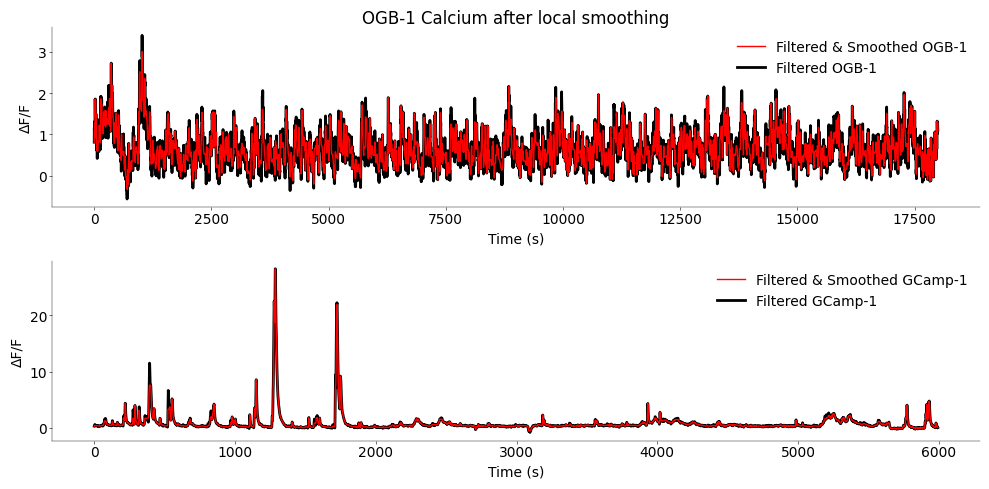

In [129]:
fig, ax = plt.subplots(2, figsize=(10, 5))

# Plot data on the first subplot
ax[0].plot(
    ogb_calcium_filtered[:, 5], color="red", zorder=5, label="Filtered & Smoothed OGB-1"
)
ax[0].plot(
    ogb_calcium_filtered_saved[:, 5], color="black", linewidth=2, label="Filtered OGB-1"
)
ax[0].set_title("OGB-1 Calcium after local smoothing")
ax[0].set_ylabel("\u0394" + "F/F")
ax[0].set_xlabel("Time (s)")
ax[0].legend()

# Plot data on the second subplot
ax[1].plot(
    gcamp_calcium_filtered[:, 6],
    color="red",
    zorder=5,
    label="Filtered & Smoothed GCamp-1",
)
ax[1].plot(
    gcamp_calcium_filtered_saved[:, 6],
    color="black",
    linewidth=2,
    label="Filtered GCamp-1",
)
ax[1].set_ylabel("\u0394" + "F/F")
ax[1].set_xlabel("Time (s)")
ax[1].legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

#### Plot the smoothed data in comparison to the filtered data

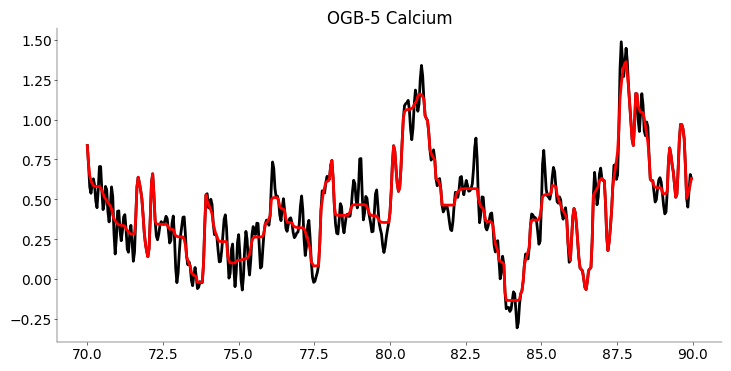

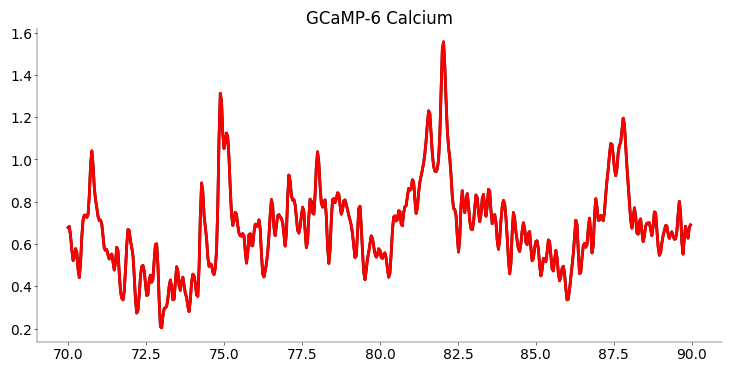

In [130]:
sample_start = 70  # seconds
example_duration = 20  # seconds


sample_end = sample_start + example_duration
sample_timeline = np.arange(sample_start, sample_end, 1 / resample_rate)
sample_data_ogb = ogb_calcium_filtered[
    sample_start * resample_rate : sample_end * resample_rate, 5
]

comparison_data_ogb = ogb_calcium_filtered_saved[
    sample_start * resample_rate : sample_end * resample_rate, 5
]

sample_data_gcamp = gcamp_calcium_filtered[
    sample_start * resample_rate : sample_end * resample_rate, 5
]

comparison_data_gcamp = gcamp_calcium_filtered_saved[
    sample_start * resample_rate : sample_end * resample_rate, 5
]

plt.plot(
    sample_timeline,
    sample_data_ogb,
    label="Smoothed fragemnt",
    color="red",
    linewidth=2,
    zorder=10,
)
plt.plot(
    sample_timeline,
    comparison_data_ogb,
    label="Original fragment",
    color="black",
    zorder=5,
    linewidth=2,
)

plt.title("OGB-5 Calcium")
plt.show()


plt.plot(
    sample_timeline,
    sample_data_gcamp,
    label="Smoothed fragemnt",
    color="red",
    linewidth=2,
    zorder=10,
)
plt.plot(
    sample_timeline,
    comparison_data_gcamp,
    label="Original fragment",
    color="black",
    zorder=5,
    linewidth=2,
)

plt.title("GCaMP-6 Calcium")
plt.show()

In [131]:
def build_kernel(kernel_duration: int, tau: float, dt: float):
    """
    Build an exponential kernel for deconvolution.

    Parameters
    ----------
    kernel_duration: int
        Duration of the kernel in time units.

    tau: float
        Decay constant for the exponential kernel.

    dt: float
        Time step for discretizing the kernel.

    Returns
    -------
    time_points: np.ndarray
        Array of time points at which the kernel is evaluated.

    kernel: np.ndarray
        The exponential kernel values at the given time points.
    """
    # Generate an array of time points from 0 to kernel_duration with step dt
    time_points = np.arange(0, kernel_duration, dt)
    # Compute the exponential decay kernel
    kernel = np.exp(-time_points / tau)
    return time_points, kernel


def deconv_ca(ca: np.ndarray, tau: float, dt: float) -> np.ndarray:
    """
    Compute the deconvolution of the calcium signal to estimate spike rates.

    Parameters
    ----------
    ca: np.ndarray, shape (n_points,)
        Calcium trace signal to be deconvolved.

    tau: float
        Decay constant of the convolution kernel.

    dt: float
        Sampling interval of the calcium trace signal.

    Returns
    -------
    sp_hat: np.ndarray
        Estimated spike rates after deconvolution.
    """
    # Determine the number of samples in the calcium trace
    num_samples = ca.size
    # Define the duration for the kernel in time units
    kernel_duration = 10
    # Build the exponential decay kernel using the given tau and dt
    time_points, exp_kernel = build_kernel(
        kernel_duration=kernel_duration, tau=tau, dt=dt
    )

    # Perform deconvolution of the calcium trace with the exponential kernel
    spike_estimate, _ = signal.deconvolve(ca, exp_kernel)
    # Ensure no negative values in the spike estimate by setting negatives to zero
    spike_estimate = np.maximum(spike_estimate, 0)

    # Initialize the output spike rate array with zeros
    sp_hat = np.zeros(num_samples)
    # Copy the valid part of the spike estimate to the output array
    sp_hat[: spike_estimate.size] = spike_estimate

    return sp_hat, exp_kernel, time_points

In [132]:
ogb_calcium_filtered_smoothed_deconv, kernel, t = deconv_ca(
    ogb_calcium_filtered[:, 5], 0.5, 1 / resample_rate
)

gcamp_calcium_filtered_smoothed_deconv, kernel_2, t_2 = deconv_ca(
    gcamp_calcium_filtered[:, 6], 0.1, 1 / resample_rate
)

smoothed_spikes_ogb = gaussian_filter1d(ogb_spikes_resampled[:, 5], 1)
smoothed_spikes_gcamp = gaussian_filter1d(gcamp_spikes_resampled[:, 6], 1)

C:\Users\Arne.Gittel\AppData\Local\Temp\ipykernel_19884\1944191079.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


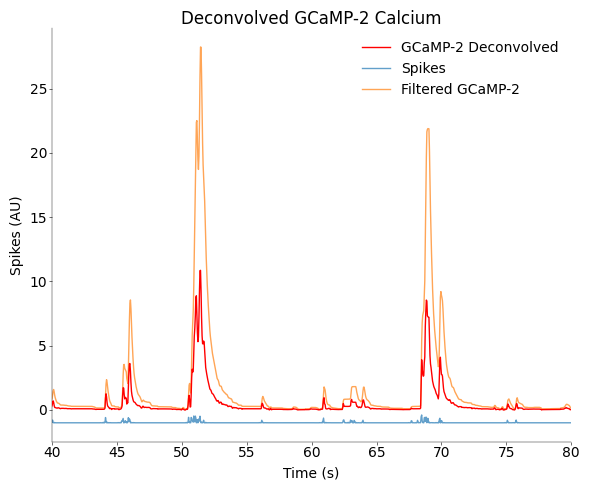

In [133]:
fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")

ax.plot(
    timeline_gcamp_resampled[0 : len(gcamp_calcium_filtered_smoothed_deconv)],
    gcamp_calcium_filtered_smoothed_deconv,
    label="GCaMP-2 Deconvolved",
    zorder=10,
    color="red",
)
ax.set_title("Deconvolved GCaMP-2 Calcium")
ax.set_ylabel("Spikes (AU)")
ax.set_xlabel("Time (s)")
ax.set_xlim([40, 80])

ax.plot(
    timeline_gcamp_resampled,
    gcamp_spikes_resampled[:, 6] - 1,
    label="Spikes",
    alpha=0.7,
)

ax.plot(
    timeline_gcamp_resampled,
    gcamp_calcium_filtered[:, 6],
    label="Filtered GCaMP-2",
    alpha=0.7,
)
plt.legend()
plt.tight_layout()
plt.show()

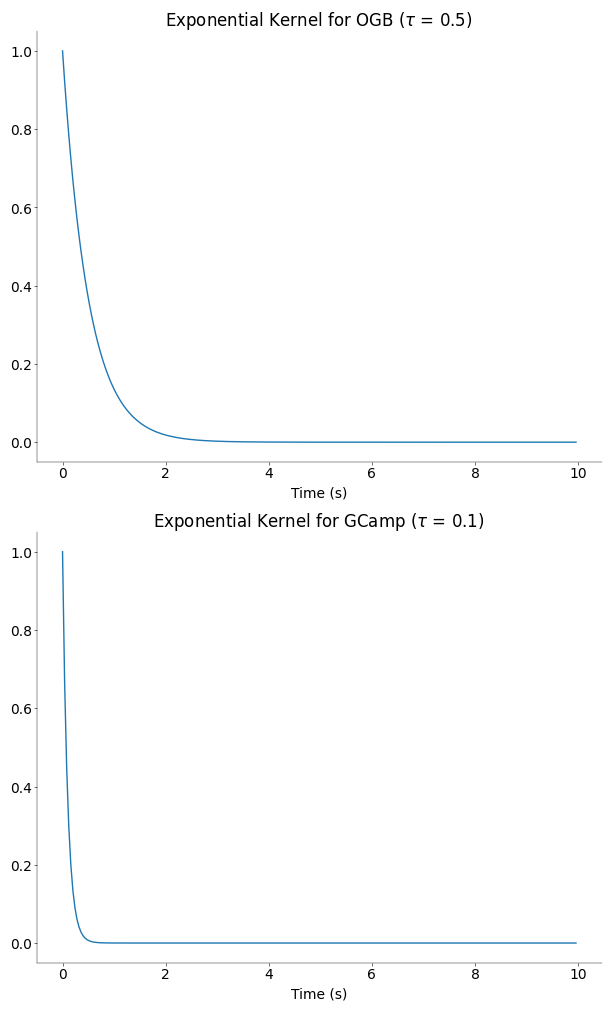

In [134]:
# Create subplots with constrained layout
fig, axs = plt.subplots(nrows=2, figsize=(6, 10), layout="constrained")

# Define cell indices for OGB and GCamp data
OGB_CELL_INDEX = 5
GCAMP_CELL_INDEX = 6

# Decimate the calcium and spike signals for both OGB and GCamp to reduce data size
OGB_calcium = signal.decimate(ogb_calcium.iloc[:, OGB_CELL_INDEX], 4)
OGB_spikes = signal.decimate(ogb_spikes.iloc[:, OGB_CELL_INDEX], 4)
GCamp_calcium = signal.decimate(gcamp_calcium.iloc[:, GCAMP_CELL_INDEX], 4)
GCamp_spikes = signal.decimate(gcamp_spikes.iloc[:, GCAMP_CELL_INDEX], 4)

# Remove negative values caused by decimation artifacts
OGB_spikes[OGB_spikes < 0] = 0
GCamp_spikes[GCamp_spikes < 0] = 0

# Define sampling frequency and kernel duration
SAMPLING_FREQUENCY = 25  # Hz
KERNEL_DURATION = 10  # seconds

# Define tau values for OGB and GCamp
OGB_TAU = 0.5  # seconds
GCAMP_TAU = 0.1  # seconds

# Calculate time step
TIME_STEP = 1 / SAMPLING_FREQUENCY  # seconds


# Create a dictionary to hold signal data and parameters
signal_dict = {
    "OGB": {
        "signal": OGB_calcium,
        "spikes": OGB_spikes,
        "deconv": None,
        "time": None,
        "kernel": None,
        "tau": OGB_TAU,
        "filtered_smoothed_signal": ogb_calcium_filtered_smoothed_deconv,
        "filtered_smoothed_spikes": smoothed_spikes_ogb,
    },
    "GCamp": {
        "signal": GCamp_calcium,
        "spikes": GCamp_spikes,
        "deconv": None,
        "time": None,
        "kernel": None,
        "tau": GCAMP_TAU,
        "filtered_smoothed_signal": gcamp_calcium_filtered_smoothed_deconv,
        "filtered_smoothed_spikes": smoothed_spikes_gcamp,
    },
}

# Perform deconvolution on the calcium signals
signal_dict["OGB"]["deconv"], _, _ = deconv_ca(
    ca=signal_dict["OGB"]["signal"], tau=signal_dict["OGB"]["tau"], dt=TIME_STEP
)
signal_dict["GCamp"]["deconv"], _, _ = deconv_ca(
    ca=signal_dict["GCamp"]["signal"], tau=signal_dict["GCamp"]["tau"], dt=TIME_STEP
)

# Generate time and kernel arrays for both OGB and GCamp
signal_dict["OGB"]["time"], signal_dict["OGB"]["kernel"] = build_kernel(
    kernel_duration=KERNEL_DURATION, tau=OGB_TAU, dt=TIME_STEP
)
signal_dict["GCamp"]["time"], signal_dict["GCamp"]["kernel"] = build_kernel(
    kernel_duration=KERNEL_DURATION, tau=GCAMP_TAU, dt=TIME_STEP
)


# Plot the kernels for both OGB and GCamp

for ax, indicator in zip(axs, signal_dict.keys()):
    ax.plot(signal_dict[indicator]["time"], signal_dict[indicator]["kernel"])
    ax.set_xlabel("Time (s)")
    ax.set_title(
        rf'Exponential Kernel for {indicator} ($\tau$ = {signal_dict[indicator]["tau"]})'
    )
# Show the plots
plt.show()

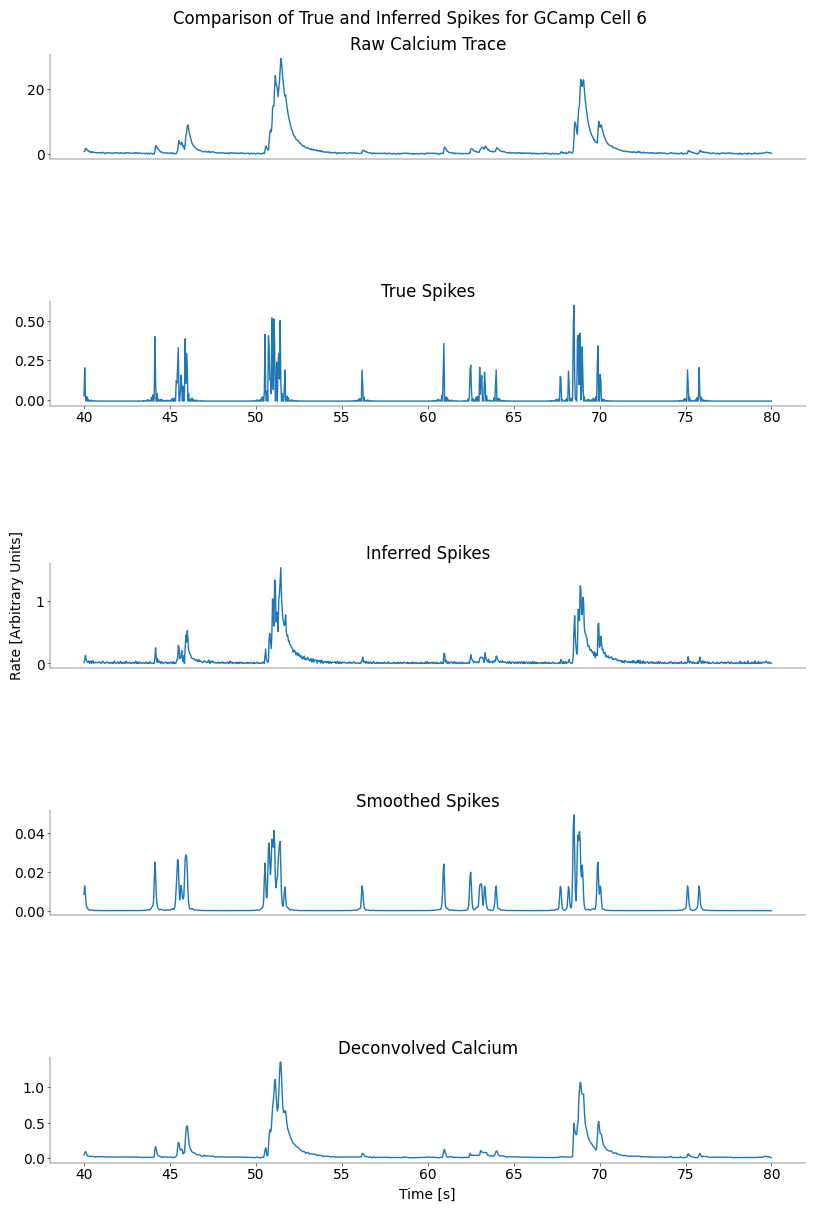

In [154]:
# --------------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB or GCamP Cell (1 pt)
# --------------------------------------------------------------------------


# Define time window for plotting
plot_time_start = 40  # start time in seconds
plot_time_end = 80  # end time in seconds
time = np.linspace(
    plot_time_start,
    plot_time_end,
    int((plot_time_end - plot_time_start) * SAMPLING_FREQUENCY),
)

# Define the indicator for GCamp cell
indicator = "GCamp"

# Create subplots with 5 rows and 1 column
fig, axs = plt.subplots(5, 1, figsize=(8, 12), gridspec_kw={"hspace": 0.5})

# Plot raw calcium trace for Gcamp cell
axs[0].plot(
    time,
    signal_dict[indicator]["signal"][
        plot_time_start * SAMPLING_FREQUENCY : plot_time_end * SAMPLING_FREQUENCY
    ],
    label=f"{indicator} Raw",
)
axs[0].set_title("Raw Calcium Trace")
axs[0].set_xticks([])

# Plot true spikes for GCamp cell
axs[1].plot(
    time,
    signal_dict[indicator]["spikes"][
        plot_time_start * SAMPLING_FREQUENCY : plot_time_end * SAMPLING_FREQUENCY
    ]
    - np.mean(signal_dict[indicator]["spikes"]),
    label=f"{indicator} True Spikes",
)
axs[1].set_title("True Spikes")
# axs[1].set_xticks([])

# Plot inferred spikes for Gcamp cell
axs[2].plot(
    time,
    signal_dict[indicator]["deconv"][
        plot_time_start * SAMPLING_FREQUENCY : plot_time_end * SAMPLING_FREQUENCY
    ]
    * (1 / 8),
    label=f"{indicator} Inferred Spikes",
)
axs[2].set_title("Inferred Spikes")
axs[2].set_xticks([])

# Plot smoothed spikes for GCamp cell
axs[3].plot(
    time,
    signal_dict[indicator]["filtered_smoothed_spikes"][
        plot_time_start * SAMPLING_FREQUENCY : plot_time_end * SAMPLING_FREQUENCY
    ]
    * (1 / 8),
    label="Smoothed Spikes",
)
axs[3].set_title("Smoothed Spikes")
axs[3].set_xticks([])

# axs[3].set_xlabel("Time [s]")

# Plot deconvolved calcium for Gcamp cell
axs[4].plot(
    time,
    signal_dict[indicator]["filtered_smoothed_signal"][
        plot_time_start * SAMPLING_FREQUENCY : plot_time_end * SAMPLING_FREQUENCY
    ]
    * (1 / 8),
    label="Deconvolved Calcium",
)
axs[4].set_title("Deconvolved Calcium")
axs[4].set_xlabel("Time [s]")


# Add figure title
fig.suptitle(
    f"Comparison of True and Inferred Spikes for {indicator} Cell {GCAMP_CELL_INDEX}"
)

# Add y label to the entire figure
fig.text(0.0, 0.5, "Rate [Arbitrary Units]", va="center", rotation="vertical")

# Show the plot
plt.show()

In [136]:
gcamp_calcium_filtered_smoothed_deconv.shape, smoothed_spikes_gcamp.shape, signal_dict[
    indicator
]["spikes"].shape

((5994,), (5994,), (5994,))

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 2 pts*



In [137]:
# run this cell to download the oopsi.py file if you haven't already mannually downloaded it
# and put it in the same folder as this notebook
#  !wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py

In [138]:
# --------------------------------------------------------------
# Apply one of the advanced algorithms on the OGB Cell (0.5 pts)
# --------------------------------------------------------------
OGB_signal = signal_dict["OGB"]["signal"]

print(OGB_signal.shape)
# Use the fast algorithm to estimate spikes
OGB_n_best, _ = oopsi.fast(OGB_signal, TIME_STEP, iter_max=1, update=True)

(17997,)


Text(0.0, 0.5, 'Rate [Arbitrary Units]')

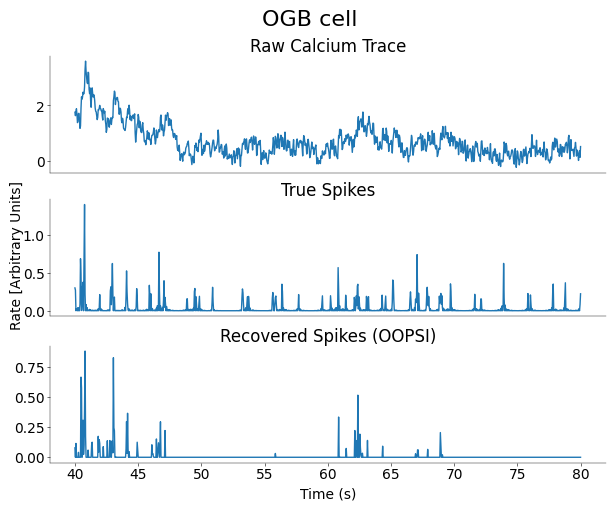

In [155]:
# -------------------------------------------
# Plot the results for the OGB Cell (0.5 pts)
# -------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 5), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)
start_time = 40
end_time = 80
# Assuming 'f' is the sampling rate
time_points = np.linspace(
    start_time, end_time, (end_time - start_time) * SAMPLING_FREQUENCY
)

axs[0].plot(
    time_points,
    signal_dict["OGB"]["signal"][
        start_time * SAMPLING_FREQUENCY : end_time * SAMPLING_FREQUENCY
    ],
)
axs[0].set_title("Raw Calcium Trace")
axs[0].set_xticks([])
axs[1].plot(
    time_points,
    signal_dict["OGB"]["spikes"][
        start_time * SAMPLING_FREQUENCY : end_time * SAMPLING_FREQUENCY
    ],
)
axs[1].set_xticks([])
axs[1].set_title("True Spikes")

axs[2].plot(
    time_points,
    OGB_n_best[start_time * SAMPLING_FREQUENCY : end_time * SAMPLING_FREQUENCY],
)
axs[2].set_xlabel("Time (s)")
axs[2].set_title("Recovered Spikes (OOPSI)")

fig.suptitle("OGB cell", fontsize=16)
fig.text(0.0, 0.5, "Rate [Arbitrary Units]", va="center", rotation="vertical")


# OGB Cell

In [140]:
# ----------------------------------------------------------------
# Apply one of the advanced algorithms on the GCamP Cell (0.5 pts)
# ----------------------------------------------------------------
GCamP_signal = signal_dict["GCamp"]["signal"]

# Use the fast algorithm to estimate spikes
GCamp_n_best, _ = oopsi.fast(GCamP_signal, TIME_STEP, iter_max=1, update=True)

Text(0.0, 0.5, 'Rate [Arbitrary Units]')

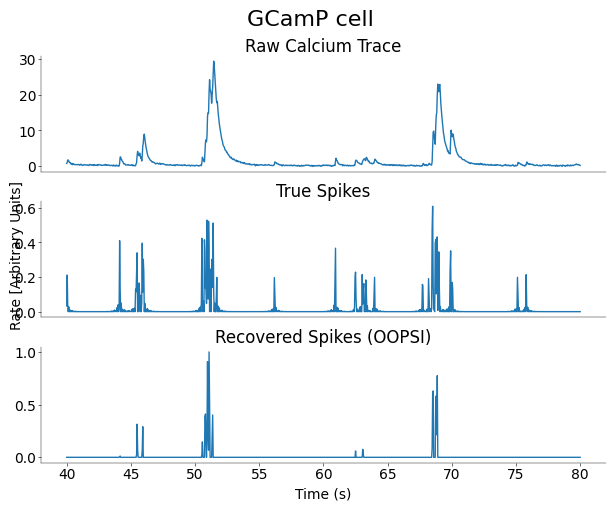

In [159]:
# ---------------------------------------------
# Plot the results for the GCamp Cell (0.5 pts)
# ---------------------------------------------
fig, axs = plt.subplots(
    3, 1, figsize=(6, 5), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)
start_time = 40
end_time = 80
time_points = np.linspace(
    start_time, end_time, (end_time - start_time) * SAMPLING_FREQUENCY
)

axs[0].plot(
    time_points,
    signal_dict["GCamp"]["signal"][
        start_time * SAMPLING_FREQUENCY : end_time * SAMPLING_FREQUENCY
    ],
)
axs[0].set_title("Raw Calcium Trace")
axs[0].set_xticks([])
axs[1].plot(
    time_points,
    signal_dict["GCamp"]["spikes"][
        start_time * SAMPLING_FREQUENCY : end_time * SAMPLING_FREQUENCY
    ],
)
axs[1].set_xticks([])
axs[1].set_title("True Spikes")

axs[2].plot(
    time_points,
    GCamp_n_best[start_time * SAMPLING_FREQUENCY : end_time * SAMPLING_FREQUENCY],
)
axs[2].set_xlabel("Time (s)")
axs[2].set_title("Recovered Spikes (OOPSI)")


fig.suptitle("GCamP cell", fontsize=16)
fig.text(0.0, 0.5, "Rate [Arbitrary Units]", va="center", rotation="vertical")

# GCamP Cell

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package.

*Grading: 3 pts*


Evaluate on OGB data

In [142]:
# -------------------------------------------------
# Create dataframe for OGB Cell as described (1 pt)
# -------------------------------------------------
dt = 1 / SAMPLING_FREQUENCY  # time step

# Initialize an empty dataframe to store results
df_ogb = pd.DataFrame(columns=["cell", "algorithm", "correlation", "indicator"])

# Loop through each cell in the OGB calcium dataset
for cell in range(ogb_calcium.shape[1]):
    # Decimate the calcium and spike signals, replacing NaNs with zeros
    ca_signal = signal.decimate(np.nan_to_num(ogb_calcium.iloc[:, cell]), 4)
    sp_signal = signal.decimate(np.nan_to_num(ogb_spikes.iloc[:, cell]), 4)

    # Perform OOPSI deconvolution
    sp_oopsi, _ = oopsi.fast(ca_signal, dt, iter_max=1, update=True)
    correlation_oopsi = np.corrcoef(sp_oopsi, sp_signal)[1, 0]

    # Append OOPSI results to the dataframe
    df_ogb = df_ogb._append(
        {
            "cell": cell,
            "algorithm": "OOPSI",
            "correlation": correlation_oopsi,
            "indicator": "OGB",
        },
        ignore_index=True,
    )

    # Perform deconvolution using a predefined function
    sp_deconv, _, _ = deconv_ca(ca_signal, dt=dt, tau=signal_dict["OGB"]["tau"])
    correlation_deconv = np.corrcoef(sp_deconv, sp_signal)[1, 0]

    # Append deconvolution results to the dataframe
    df_ogb = df_ogb._append(
        {
            "cell": cell,
            "algorithm": "deconv",
            "correlation": correlation_deconv,
            "indicator": "OGB",
        },
        ignore_index=True,
    )

# Display the dataframe
print(df_ogb)

C:\Users\Arne.Gittel\AppData\Local\Temp\ipykernel_19884\496898155.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ogb = df_ogb._append(


   cell algorithm  correlation indicator
0     0     OOPSI     0.470173       OGB
1     0    deconv     0.374256       OGB
2     1     OOPSI     0.281346       OGB
3     1    deconv     0.136248       OGB
4     2     OOPSI     0.389922       OGB
5     2    deconv     0.160615       OGB
6     3     OOPSI     0.384532       OGB
7     3    deconv     0.237181       OGB
8     4     OOPSI     0.444624       OGB
9     4    deconv     0.280824       OGB
10    5     OOPSI     0.351155       OGB
11    5    deconv     0.263929       OGB
12    6     OOPSI     0.404366       OGB
13    6    deconv     0.269975       OGB
14    7     OOPSI     0.438737       OGB
15    7    deconv     0.279041       OGB
16    8     OOPSI     0.328897       OGB
17    8    deconv     0.154109       OGB
18    9     OOPSI     0.354832       OGB
19    9    deconv     0.301529       OGB
20   10     OOPSI     0.404284       OGB
21   10    deconv     0.170360       OGB


Create OGB dataframe

In [143]:
df_ogb.head()

,cell,algorithm,correlation,indicator
0,0,OOPSI,0.470173,OGB
1,0,deconv,0.374256,OGB
2,1,OOPSI,0.281346,OGB
3,1,deconv,0.136248,OGB
4,2,OOPSI,0.389922,OGB


Evaluate on GCamp data

In [144]:
# Initialize an empty DataFrame to store results for GCaMP cells
df_gcamp = pd.DataFrame(columns=["cell", "algorithm", "correlation", "indicator"])

# Loop through each cell in the GCaMP calcium dataset
for cell in range(gcamp_calcium.shape[1]):
    # Decimate the calcium and spike signals, replacing NaNs with zeros
    ca_signal = signal.decimate(np.nan_to_num(gcamp_calcium.iloc[:, cell]), 4)
    sp_signal = signal.decimate(np.nan_to_num(gcamp_spikes.iloc[:, cell]), 4)

    # OOPSI algorithm
    sp_oopsi, _ = oopsi.fast(ca_signal, dt, iter_max=1, update=True)
    correlation_oopsi = np.corrcoef(sp_oopsi, sp_signal)[1, 0]

    # Append OOPSI results to the DataFrame
    df_gcamp = df_gcamp._append(
        {
            "cell": cell,
            "algorithm": "OOPSI",
            "correlation": correlation_oopsi,
            "indicator": "GCAMP",
        },
        ignore_index=True,
    )

    # Deconvolution algorithm
    sp_deconv, _, _ = deconv_ca(ca_signal, dt=dt, tau=signal_dict["GCamp"]["tau"])
    correlation_deconv = np.corrcoef(sp_deconv, sp_signal)[1, 0]

    # Append deconvolution results to the DataFrame
    df_gcamp = df_gcamp._append(
        {
            "cell": cell,
            "algorithm": "deconv",
            "correlation": correlation_deconv,
            "indicator": "GCAMP",
        },
        ignore_index=True,
    )

# Display the DataFrame
print(df_gcamp)

C:\Users\Arne.Gittel\AppData\Local\Temp\ipykernel_19884\4283492236.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_gcamp = df_gcamp._append(


   cell algorithm  correlation indicator
0     0     OOPSI     0.532781     GCAMP
1     0    deconv     0.496494     GCAMP
2     1     OOPSI     0.613326     GCAMP
3     1    deconv     0.428740     GCAMP
4     2     OOPSI     0.483969     GCAMP
..  ...       ...          ...       ...
69   34    deconv     0.442205     GCAMP
70   35     OOPSI     0.584769     GCAMP
71   35    deconv     0.459272     GCAMP
72   36     OOPSI     0.622176     GCAMP
73   36    deconv     0.241995     GCAMP

[74 rows x 4 columns]


Create GCamp dataframe

In [145]:
df_gcamp.head()

,cell,algorithm,correlation,indicator
0,0,OOPSI,0.532781,GCAMP
1,0,deconv,0.496494,GCAMP
2,1,OOPSI,0.613326,GCAMP
3,1,deconv,0.428740,GCAMP
4,2,OOPSI,0.483969,GCAMP


Combine both dataframes and plot

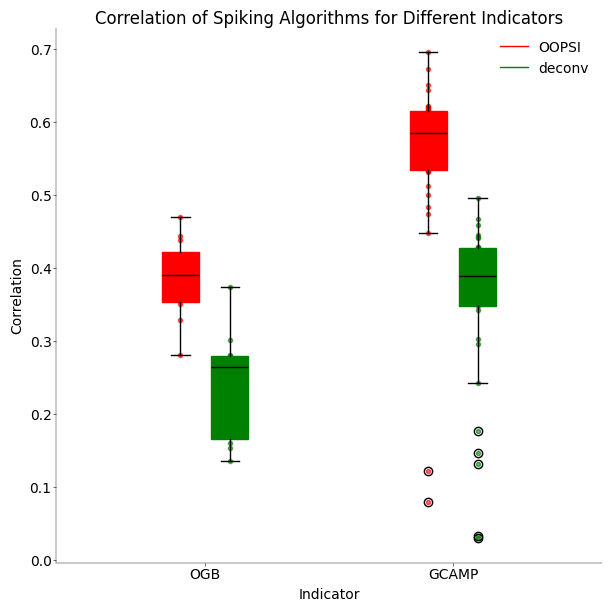

In [146]:
# ---------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described (1 pt)
# hint: you can seperate the algorithms by color
# ---------------------------------------------------------------------------
# Combine the two dataframes
df_comb = pd.concat([df_ogb, df_gcamp])

# Unique indicators and algorithms
indicators = df_comb["indicator"].unique()
algorithms = df_comb["algorithm"].unique()

# Define colors for the algorithms
colors = {"OOPSI": "red", "deconv": "green"}

# Create a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Create boxplots for each indicator
for i, indicator in enumerate(indicators):
    for j, algorithm in enumerate(algorithms):
        # Filter data
        data = df_comb[
            (df_comb["indicator"] == indicator) & (df_comb["algorithm"] == algorithm)
        ]["correlation"]

        # Boxplot
        bp = ax.boxplot(
            data,
            positions=[i + j * 0.2 - 0.1],  # slight shift for each algorithm
            widths=0.15,
            patch_artist=True,
            boxprops=dict(facecolor=colors[algorithm], color=colors[algorithm]),
            medianprops=dict(color="black"),
        )

        # Strip plot
        ax.scatter(
            np.full(data.shape, i + j * 0.2 - 0.1),
            data,
            color=colors[algorithm],
            alpha=0.6,
        )

# Set the x-axis labels
ax.set_xticks(range(len(indicators)))
ax.set_xticklabels(indicators)

# Add legend
for algorithm, color in colors.items():
    ax.plot([], [], color=color, label=algorithm)
ax.legend()

# Set labels and title
ax.set_xlabel("Indicator")
ax.set_ylabel("Correlation")
ax.set_title("Correlation of Spiking Algorithms for Different Indicators")

# Show plot
plt.show()

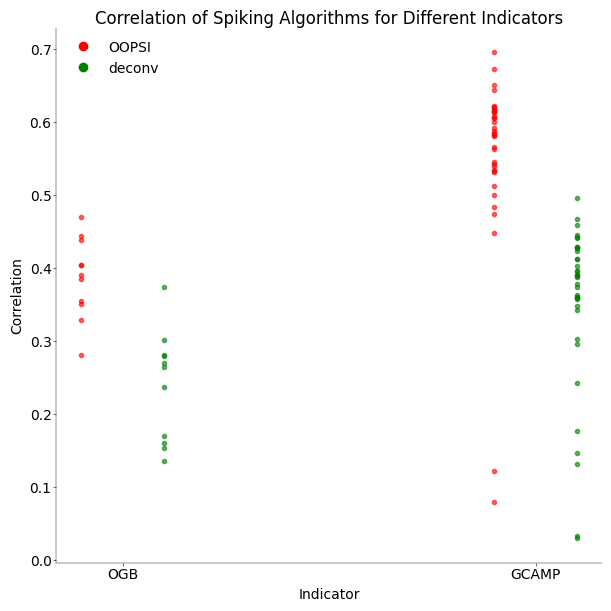

In [147]:
# Unique indicators and algorithms
indicators = df_comb["indicator"].unique()
algorithms = df_comb["algorithm"].unique()

# Define colors for the algorithms
colors = {"OOPSI": "red", "deconv": "green"}

# Create a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Create stripplots for each indicator
for i, indicator in enumerate(indicators):
    for j, algorithm in enumerate(algorithms):
        # Filter data
        data = df_comb[
            (df_comb["indicator"] == indicator) & (df_comb["algorithm"] == algorithm)
        ]["correlation"]

        # Strip plot
        ax.scatter(
            np.full(data.shape, i + j * 0.2 - 0.1),
            data,
            color=colors[algorithm],
            alpha=0.6,
            label=algorithm if i == 0 else None,  # Show legend labels only once
        )

# Set the x-axis labels
ax.set_xticks(range(len(indicators)))
ax.set_xticklabels(indicators)

# Add legend
handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=algorithm,
        markersize=8,
        markerfacecolor=color,
    )
    for algorithm, color in colors.items()
]
ax.legend(handles=handles)

# Set labels and title
ax.set_xlabel("Indicator")
ax.set_ylabel("Correlation")
ax.set_title("Correlation of Spiking Algorithms for Different Indicators")

# Show plot
plt.show()

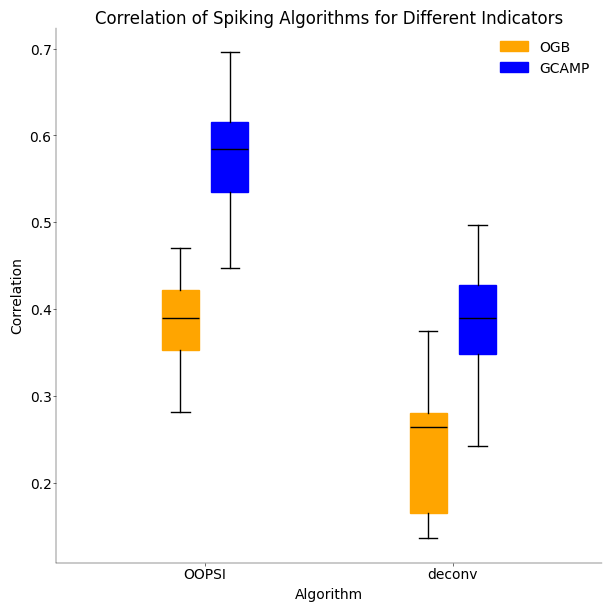

In [148]:
# Unique indicators and algorithms
indicators = df_comb["indicator"].unique()
algorithms = df_comb["algorithm"].unique()

# Define colors for the indicators
colors = {"OGB": "orange", "GCAMP": "blue"}

# Create a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Create boxplots for each algorithm
for i, algorithm in enumerate(algorithms):
    for j, indicator in enumerate(indicators):
        # Filter data
        data = df_comb[
            (df_comb["algorithm"] == algorithm) & (df_comb["indicator"] == indicator)
        ]["correlation"]

        # Boxplot
        bp = ax.boxplot(
            data,
            positions=[i + j * 0.2 - 0.1],  # slight shift for each indicator
            widths=0.15,
            patch_artist=True,
            boxprops=dict(facecolor=colors[indicator], color=colors[indicator]),
            medianprops=dict(color="black"),
            labels=[algorithm if j == 0 else None],  # Show algorithm labels only once
            sym="",  # Don't show outliers
        )

# Set the x-axis labels
ax.set_xticks(range(len(algorithms)))
ax.set_xticklabels(algorithms)

# Add legend
handles = [
    plt.Rectangle((0, 0), 1, 1, color=color, label=indicator)
    for indicator, color in colors.items()
]
ax.legend(handles=handles)

# Set labels and title
ax.set_xlabel("Algorithm")
ax.set_ylabel("Correlation")
ax.set_title("Correlation of Spiking Algorithms for Different Indicators")

# Show plot
plt.show()

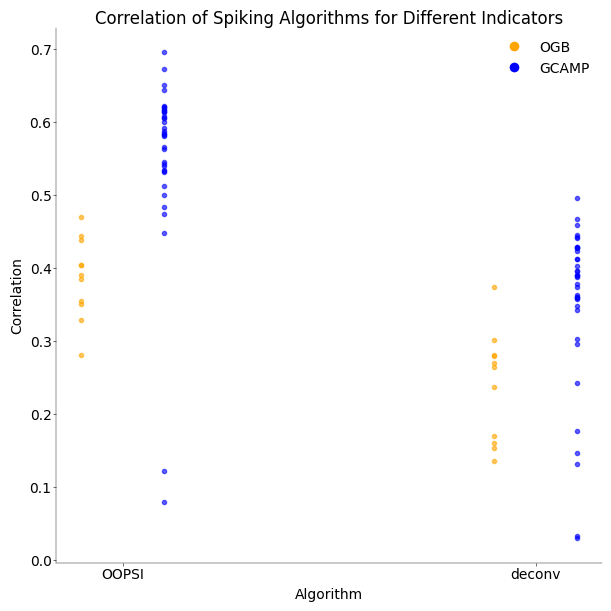

In [149]:
# Unique indicators and algorithms
indicators = df_comb["indicator"].unique()
algorithms = df_comb["algorithm"].unique()

# Define colors for the indicators
colors = {"OGB": "orange", "GCAMP": "blue"}

# Create a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Create stripplots for each algorithm
for i, algorithm in enumerate(algorithms):
    for j, indicator in enumerate(indicators):
        # Filter data
        data = df_comb[
            (df_comb["algorithm"] == algorithm) & (df_comb["indicator"] == indicator)
        ]["correlation"]

        # Strip plot
        ax.scatter(
            np.full(data.shape, i + j * 0.2 - 0.1),
            data,
            color=colors[indicator],
            alpha=0.6,
            label=indicator if i == 0 else None,  # Show indicator labels only once
        )

# Set the x-axis labels
ax.set_xticks(range(len(algorithms)))
ax.set_xticklabels(algorithms)

# Add legend
handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=indicator,
        markersize=8,
        markerfacecolor=color,
    )
    for indicator, color in colors.items()
]
ax.legend(handles=handles)

# Set labels and title
ax.set_xlabel("Algorithm")
ax.set_ylabel("Correlation")
ax.set_title("Correlation of Spiking Algorithms for Different Indicators")

# Show plot
plt.show()